<a href="https://colab.research.google.com/github/Dimka27/Projects/blob/main/Hackaton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U catalyst
!pip install -U vit-pytorch

     |████████████████████████████████| 536 kB 7.4 MB/s 
     |████████████████████████████████| 636 kB 31.4 MB/s 
     |████████████████████████████████| 120 kB 72.1 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Data

In [ ]:
'''!cp /content/drive/MyDrive/Hackaton/avia-test.zip /content
!cp /content/drive/MyDrive/Hackaton/avia-train.zip /content
!cp /content/drive/MyDrive/Hackaton/sample_submission.csv /content
!cp /content/drive/MyDrive/Hackaton/test.csv /content
!cp /content/drive/MyDrive/Hackaton/train.csv /content
!unzip avia-test.zip > /dev/null
!unzip avia-train.zip > /dev/null'''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/Пропавшие самолеты/avia-test.zip' /content
!cp '/content/drive/MyDrive/Пропавшие самолеты/avia-train.zip' /content
!cp '/content/drive/MyDrive/Пропавшие самолеты/sample_submission.csv' /content
!cp '/content/drive/MyDrive/Пропавшие самолеты/test.csv' /content
!cp '/content/drive/MyDrive/Пропавшие самолеты/train.csv' /content
!unzip avia-test.zip > /dev/null
!unzip avia-train.zip > /dev/null

In [ ]:
import shutil

from os.path import join as join_path

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from vit_pytorch import ViT
from catalyst import dl, callbacks
from sklearn.model_selection import train_test_split
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tt

%matplotlib inline
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
df_training = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [ ]:
def calculate_weights(df):
    length = len(df.sign)
    weights = torch.tensor([(length - np.sum(df.sign == 0)) / length,
                            (length - np.sum(df.sign == 1)) / length], dtype=torch.float)
    maximum = torch.max(weights)
    weights = weights / maximum
    return weights

weights = calculate_weights(df_training)
print('Weights:', weights)
weights = weights.to(DEVICE)

Weights: tensor([0.3408, 1.0000])


In [ ]:
train, valid = train_test_split(df_training, test_size=0.3, stratify=df_training.sign, random_state=228)

In [ ]:
print('Weights:', calculate_weights(train))
print('Weights:', calculate_weights(valid))

Weights: tensor([0.3407, 1.0000])
Weights: tensor([0.3408, 1.0000])


In [ ]:
class SmallImage(Dataset):
    def __init__(self, folder, csv, transforms=None, is_train=True, is_one_hot_enc=True):
        self.folder = folder
        self.csv = csv
        self.transforms = transforms
        self.is_train = is_train
        self.is_one_hot_enc = is_one_hot_enc
    
    def __getitem__(self, index):
        image_path = join_path(self.folder, self.csv.filename.iat[index]+'.png')
        image = Image.open(image_path)
        if self.transforms:
            image = self.transforms(image)
        image = image[:3, :, :]
        if self.is_train:
            if self.is_one_hot_enc:
                label = torch.tensor([0, 1], dtype=torch.float) if self.csv.sign.iat[index] else torch.tensor([1, 0], dtype=torch.float)
            else:
                label = torch.tensor([self.csv.sign.iat[index]], dtype=torch.float)
            return {'features': image, 'targets': label}
        return {'features': image}
    
    def __len__(self):
        return self.csv.shape[0]

In [ ]:
print('All data:  ', df_training.shape[0],
      '\nTrain part:', train.shape[0],
      '\nValid part: ', valid.shape[0])

All data:   31080 
Train part: 21756 
Valid part:  9324


In [ ]:
train_transform = tt.Compose(
    [
     tt.RandomHorizontalFlip(),
     tt.RandomVerticalFlip(),
     tt.ToTensor(),
     tt.Normalize(mean=0.5, std=0.5)
    ]
    )
test_transform = tt.Compose(
    [
     tt.ToTensor(),
     tt.Normalize(mean=0.5, std=0.5)
    ]
    )

In [ ]:
def denormalization(image):
    return (image * 0.5 + 0.5).detach().cpu().permute(1, 2, 0).numpy()

In [ ]:
one_hot = False

train_dataset = SmallImage('./avia-train', train, transforms=train_transform, is_one_hot_enc=one_hot)
valid_dataset = SmallImage('./avia-train', valid, transforms=test_transform, is_one_hot_enc=one_hot)
test_dataset = SmallImage('./avia-test', df_test, transforms=test_transform, is_one_hot_enc=one_hot, is_train=False)

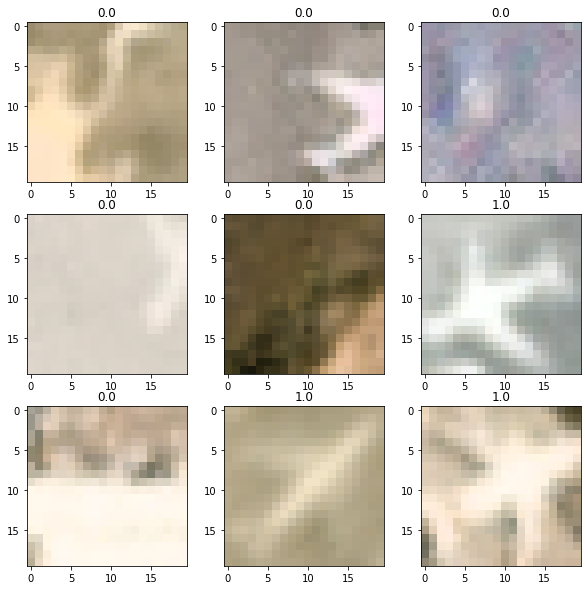

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    if train_dataset.is_one_hot_enc:
        plt.title('0' if train_dataset[i]['targets'][0].item() == 1 else '1')
    else:
        plt.title(train_dataset[i]['targets'][0].item())
    plt.imshow(denormalization(train_dataset[i]['features']))   

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=224, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=224, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=224, shuffle=False, num_workers=2)

In [ ]:
loader = {'train': train_loader,
          'valid': valid_loader}

# Transformer and learn transformer

In [ ]:
model_vit = ViT(
    image_size = 20,
    patch_size = 20,
    num_classes = 1,
    dim = 256,
    depth = 8,
    heads = 8,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)
model_vit = model_vit.to(DEVICE)

In [ ]:
img = torch.rand(224, 3, 20, 20, device=DEVICE)
with torch.no_grad():
    print(model_vit(img).shape)

torch.Size([224, 1])


### Start structure:
image_size = 20,
    patch_size = 5,
    num_classes = 2,
    dim = 256,
    depth = 8,
    heads = 8,
    mlp_dim = 1024,
    dropout = 0.2,
    emb_dropout = 0.2

In [ ]:
weights = weights.to(DEVICE)
# criterion = nn.BCEWithLogitsLoss(weight=weights)
criterion = nn.BCEWithLogitsLoss()

lr = 3e-4
optimizer = optim.Adam(model_vit.parameters(), lr=lr)

lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=1, epochs=10000)

In [ ]:
runner = dl.SupervisedRunner()

In [ ]:
runner.train(model=model_vit,
             criterion=criterion,
             optimizer=optimizer,
             scheduler=lr_scheduler,
             loaders=loader,
             num_epochs=100,
             logdir="./logs",
             verbose=True,
             load_best_on_end=True,
             valid_loader="valid",
             valid_metric="loss"
             )


train (1/100) loss: 0.5547573566436768 | loss/mean: 0.5547573566436768 | loss/std: 0.055762707465155076 | lr: 1.200000000000002e-05 | momentum: 0.95



valid (1/100) loss: 0.5003628134727478 | loss/mean: 0.5003628134727478 | loss/std: 0.04852922003708192 | lr: 1.200000000000002e-05 | momentum: 0.95
* Epoch (1/100) lr: 1.200007900949222e-05 | momentum: 0.9499999725661485



train (2/100) loss: 0.4856397211551666 | loss/mean: 0.4856397211551666 | loss/std: 0.03610441795613877 | lr: 1.200007900949222e-05 | momentum: 0.9499999725661485



valid (2/100) loss: 0.44322308897972107 | loss/mean: 0.44322308897972107 | loss/std: 0.03771974728574906 | lr: 1.200007900949222e-05 | momentum: 0.9499999725661485
* Epoch (2/100) lr: 1.2000316037882137e-05 | momentum: 0.9499998902646242



train (3/100) loss: 0.423951119184494 | loss/mean: 0.423951119184494 | loss/std: 0.04467541145631446 | lr: 1.2000316037882137e-05 | momentum: 0.9499998902646242



valid (3/100) loss: 0.5285284519195557 | loss/mean: 0.5285284519195557 | loss/std: 0.06402745352160864 | lr: 1.2000316037882137e-05 | momentum: 0.9499998902646242
* Epoch (3/100) lr: 1.2000711084909617e-05 | momentum: 0.9499997530955174



train (4/100) loss: 0.3727143406867981 | loss/mean: 0.3727143406867981 | loss/std: 0.03602734926209706 | lr: 1.2000711084909617e-05 | momentum: 0.9499997530955174



valid (4/100) loss: 0.49730828404426575 | loss/mean: 0.49730828404426575 | loss/std: 0.04572693978887909 | lr: 1.2000711084909617e-05 | momentum: 0.9499997530955174
* Epoch (4/100) lr: 1.200126415014125e-05 | momentum: 0.9499995610589786



train (5/100) loss: 0.332046777009964 | loss/mean: 0.332046777009964 | loss/std: 0.03793696405776121 | lr: 1.200126415014125e-05 | momentum: 0.9499995610589786



valid (5/100) loss: 0.4704412519931793 | loss/mean: 0.4704412519931793 | loss/std: 0.06200267100636694 | lr: 1.200126415014125e-05 | momentum: 0.9499995610589786
* Epoch (5/100) lr: 1.2001975232970045e-05 | momentum: 0.9499993141552187



train (6/100) loss: 0.31410807371139526 | loss/mean: 0.31410807371139526 | loss/std: 0.037698325468022285 | lr: 1.2001975232970045e-05 | momentum: 0.9499993141552187



valid (6/100) loss: 0.5624344944953918 | loss/mean: 0.5624344944953918 | loss/std: 0.054449036857633144 | lr: 1.2001975232970045e-05 | momentum: 0.9499993141552187
* Epoch (6/100) lr: 1.2002844332615703e-05 | momentum: 0.9499990123845083



train (7/100) loss: 0.3016122877597809 | loss/mean: 0.3016122877597809 | loss/std: 0.03843761700121012 | lr: 1.2002844332615703e-05 | momentum: 0.9499990123845083



valid (7/100) loss: 0.5572946071624756 | loss/mean: 0.5572946071624756 | loss/std: 0.07202117679941471 | lr: 1.2002844332615703e-05 | momentum: 0.9499990123845083
* Epoch (7/100) lr: 1.2003871448124613e-05 | momentum: 0.9499986557471789



train (8/100) loss: 0.2878122329711914 | loss/mean: 0.2878122329711914 | loss/std: 0.039868407862536655 | lr: 1.2003871448124613e-05 | momentum: 0.9499986557471789



valid (8/100) loss: 0.48147717118263245 | loss/mean: 0.48147717118263245 | loss/std: 0.06476527130982804 | lr: 1.2003871448124613e-05 | momentum: 0.9499986557471789
* Epoch (8/100) lr: 1.2005056578369476e-05 | momentum: 0.9499982442436217



train (9/100) loss: 0.27543580532073975 | loss/mean: 0.27543580532073975 | loss/std: 0.03656692187093751 | lr: 1.2005056578369476e-05 | momentum: 0.9499982442436217



valid (9/100) loss: 0.5230457782745361 | loss/mean: 0.5230457782745361 | loss/std: 0.07065997833053962 | lr: 1.2005056578369476e-05 | momentum: 0.9499982442436217
* Epoch (9/100) lr: 1.2006399722049954e-05 | momentum: 0.9499977778742882



train (10/100) loss: 0.26389580965042114 | loss/mean: 0.26389580965042114 | loss/std: 0.039012453706980914 | lr: 1.2006399722049954e-05 | momentum: 0.9499977778742882



valid (10/100) loss: 0.5613917708396912 | loss/mean: 0.5613917708396912 | loss/std: 0.07597177677250436 | lr: 1.2006399722049954e-05 | momentum: 0.9499977778742882
* Epoch (10/100) lr: 1.2007900877692075e-05 | momentum: 0.9499972566396903



train (11/100) loss: 0.2547484338283539 | loss/mean: 0.2547484338283539 | loss/std: 0.041186054806464326 | lr: 1.2007900877692075e-05 | momentum: 0.9499972566396903



valid (11/100) loss: 0.5085960626602173 | loss/mean: 0.5085960626602173 | loss/std: 0.06539390266828736 | lr: 1.2007900877692075e-05 | momentum: 0.9499972566396903
* Epoch (11/100) lr: 1.20095600436485e-05 | momentum: 0.9499966805403998



train (12/100) loss: 0.2504214346408844 | loss/mean: 0.2504214346408844 | loss/std: 0.03897397815510717 | lr: 1.20095600436485e-05 | momentum: 0.9499966805403998



valid (12/100) loss: 0.5574750900268555 | loss/mean: 0.5574750900268555 | loss/std: 0.07643577248832065 | lr: 1.20095600436485e-05 | momentum: 0.9499966805403998
* Epoch (12/100) lr: 1.201137721809864e-05 | momentum: 0.9499960495770491



train (13/100) loss: 0.2444552779197693 | loss/mean: 0.2444552779197693 | loss/std: 0.03919141471554499 | lr: 1.201137721809864e-05 | momentum: 0.9499960495770491



valid (13/100) loss: 0.5272679924964905 | loss/mean: 0.5272679924964905 | loss/std: 0.0609379214762561 | lr: 1.201137721809864e-05 | momentum: 0.9499960495770491
* Epoch (13/100) lr: 1.2013352399048319e-05 | momentum: 0.9499953637503304



train (14/100) loss: 0.23860900104045868 | loss/mean: 0.23860900104045868 | loss/std: 0.035113844369205796 | lr: 1.2013352399048319e-05 | momentum: 0.9499953637503304



valid (14/100) loss: 0.5260472893714905 | loss/mean: 0.5260472893714905 | loss/std: 0.07569476789126625 | lr: 1.2013352399048319e-05 | momentum: 0.9499953637503304
* Epoch (14/100) lr: 1.201548558433011e-05 | momentum: 0.9499946230609965



train (15/100) loss: 0.24175700545310974 | loss/mean: 0.24175700545310974 | loss/std: 0.03947981243169178 | lr: 1.201548558433011e-05 | momentum: 0.9499946230609965



valid (15/100) loss: 0.4635201096534729 | loss/mean: 0.4635201096534729 | loss/std: 0.06166250406965661 | lr: 1.201548558433011e-05 | momentum: 0.9499946230609965
* Epoch (15/100) lr: 1.2017776771603111e-05 | momentum: 0.94999382750986



train (16/100) loss: 0.23421627283096313 | loss/mean: 0.23421627283096313 | loss/std: 0.03484915301426405 | lr: 1.2017776771603111e-05 | momentum: 0.94999382750986



valid (16/100) loss: 0.5246424078941345 | loss/mean: 0.5246424078941345 | loss/std: 0.06468687894634889 | lr: 1.2017776771603111e-05 | momentum: 0.94999382750986
* Epoch (16/100) lr: 1.2020225958353167e-05 | momentum: 0.949992977097794



train (17/100) loss: 0.23157508671283722 | loss/mean: 0.23157508671283722 | loss/std: 0.039388990013805796 | lr: 1.2020225958353167e-05 | momentum: 0.949992977097794



valid (17/100) loss: 0.4316687285900116 | loss/mean: 0.4316687285900116 | loss/std: 0.06956746273033881 | lr: 1.2020225958353167e-05 | momentum: 0.949992977097794
* Epoch (17/100) lr: 1.202283314189254e-05 | momentum: 0.9499920718257318



train (18/100) loss: 0.22903189063072205 | loss/mean: 0.22903189063072205 | loss/std: 0.035301783443747514 | lr: 1.202283314189254e-05 | momentum: 0.9499920718257318



valid (18/100) loss: 0.478066086769104 | loss/mean: 0.478066086769104 | loss/std: 0.07736276309943753 | lr: 1.202283314189254e-05 | momentum: 0.9499920718257318
* Epoch (18/100) lr: 1.2025598319360291e-05 | momentum: 0.9499911116946665



train (19/100) loss: 0.2278909832239151 | loss/mean: 0.2278909832239151 | loss/std: 0.040631553847432965 | lr: 1.2025598319360291e-05 | momentum: 0.9499911116946665



valid (19/100) loss: 0.43163904547691345 | loss/mean: 0.43163904547691345 | loss/std: 0.061311506291721975 | lr: 1.2025598319360291e-05 | momentum: 0.9499911116946665
* Epoch (19/100) lr: 1.2028521487722065e-05 | momentum: 0.949990096705652



train (20/100) loss: 0.22449782490730286 | loss/mean: 0.22449782490730286 | loss/std: 0.03757754312361167 | lr: 1.2028521487722065e-05 | momentum: 0.949990096705652



valid (20/100) loss: 0.4165104329586029 | loss/mean: 0.4165104329586029 | loss/std: 0.05355422188886329 | lr: 1.2028521487722065e-05 | momentum: 0.949990096705652
* Epoch (20/100) lr: 1.2031602643770031e-05 | momentum: 0.949989026859802



train (21/100) loss: 0.22624321281909943 | loss/mean: 0.22624321281909943 | loss/std: 0.03803657318503806 | lr: 1.2031602643770031e-05 | momentum: 0.949989026859802



valid (21/100) loss: 0.44623076915740967 | loss/mean: 0.44623076915740967 | loss/std: 0.06445378809148546 | lr: 1.2031602643770031e-05 | momentum: 0.949989026859802
* Epoch (21/100) lr: 1.2034841784123106e-05 | momentum: 0.9499879021582905



train (22/100) loss: 0.22366639971733093 | loss/mean: 0.22366639971733093 | loss/std: 0.03450491736836359 | lr: 1.2034841784123106e-05 | momentum: 0.9499879021582905



valid (22/100) loss: 0.4340459406375885 | loss/mean: 0.4340459406375885 | loss/std: 0.06550276408716044 | lr: 1.2034841784123106e-05 | momentum: 0.9499879021582905
* Epoch (22/100) lr: 1.2038238905226896e-05 | momentum: 0.9499867226023517



train (23/100) loss: 0.2217351198196411 | loss/mean: 0.2217351198196411 | loss/std: 0.03743183160870932 | lr: 1.2038238905226896e-05 | momentum: 0.9499867226023517



valid (23/100) loss: 0.4484461843967438 | loss/mean: 0.4484461843967438 | loss/std: 0.07116629976980204 | lr: 1.2038238905226896e-05 | momentum: 0.9499867226023517
* Epoch (23/100) lr: 1.2041794003353425e-05 | momentum: 0.94998548819328



train (24/100) loss: 0.21615436673164368 | loss/mean: 0.21615436673164368 | loss/std: 0.03475722436509284 | lr: 1.2041794003353425e-05 | momentum: 0.94998548819328



valid (24/100) loss: 0.39341866970062256 | loss/mean: 0.39341866970062256 | loss/std: 0.05690881389670899 | lr: 1.2041794003353425e-05 | momentum: 0.94998548819328
* Epoch (24/100) lr: 1.204550707460157e-05 | momentum: 0.94998419893243



train (25/100) loss: 0.21626901626586914 | loss/mean: 0.21626901626586914 | loss/std: 0.03147941276835197 | lr: 1.204550707460157e-05 | momentum: 0.94998419893243



valid (25/100) loss: 0.3934566378593445 | loss/mean: 0.3934566378593445 | loss/std: 0.06809032725992356 | lr: 1.204550707460157e-05 | momentum: 0.94998419893243
* Epoch (25/100) lr: 1.2049378114896685e-05 | momentum: 0.9499828548212164



train (26/100) loss: 0.21425458788871765 | loss/mean: 0.21425458788871765 | loss/std: 0.03976390749629791 | lr: 1.2049378114896685e-05 | momentum: 0.9499828548212164



valid (26/100) loss: 0.39699679613113403 | loss/mean: 0.39699679613113403 | loss/std: 0.05895964920360206 | lr: 1.2049378114896685e-05 | momentum: 0.9499828548212164
* Epoch (26/100) lr: 1.2053407119990973e-05 | momentum: 0.9499814558611142



train (27/100) loss: 0.2122715562582016 | loss/mean: 0.2122715562582016 | loss/std: 0.03540072339196288 | lr: 1.2053407119990973e-05 | momentum: 0.9499814558611142



valid (27/100) loss: 0.3392234742641449 | loss/mean: 0.3392234742641449 | loss/std: 0.0587057886010653 | lr: 1.2053407119990973e-05 | momentum: 0.9499814558611142
* Epoch (27/100) lr: 1.2057594085463166e-05 | momentum: 0.9499800020536586



train (28/100) loss: 0.21080434322357178 | loss/mean: 0.21080434322357178 | loss/std: 0.03533507247678769 | lr: 1.2057594085463166e-05 | momentum: 0.9499800020536586



valid (28/100) loss: 0.38489222526550293 | loss/mean: 0.38489222526550293 | loss/std: 0.06948960701018773 | lr: 1.2057594085463166e-05 | momentum: 0.9499800020536586
* Epoch (28/100) lr: 1.2061939006718686e-05 | momentum: 0.9499784934004448



train (29/100) loss: 0.2134237438440323 | loss/mean: 0.2134237438440323 | loss/std: 0.033660764880106185 | lr: 1.2061939006718686e-05 | momentum: 0.9499784934004448



valid (29/100) loss: 0.36699381470680237 | loss/mean: 0.36699381470680237 | loss/std: 0.056997972332948746 | lr: 1.2061939006718686e-05 | momentum: 0.9499784934004448
* Epoch (29/100) lr: 1.2066441878989538e-05 | momentum: 0.9499769299031287



train (30/100) loss: 0.2083004266023636 | loss/mean: 0.2083004266023636 | loss/std: 0.0363385481007215 | lr: 1.2066441878989538e-05 | momentum: 0.9499769299031287



valid (30/100) loss: 0.3623342514038086 | loss/mean: 0.3623342514038086 | loss/std: 0.05574783514073527 | lr: 1.2066441878989538e-05 | momentum: 0.9499769299031287
* Epoch (30/100) lr: 1.2071102697334523e-05 | momentum: 0.9499753115634255



train (31/100) loss: 0.2072882354259491 | loss/mean: 0.2072882354259491 | loss/std: 0.03387871970550984 | lr: 1.2071102697334523e-05 | momentum: 0.9499753115634255



valid (31/100) loss: 0.38079285621643066 | loss/mean: 0.38079285621643066 | loss/std: 0.06113708826751825 | lr: 1.2071102697334523e-05 | momentum: 0.9499753115634255
* Epoch (31/100) lr: 1.2075921456639136e-05 | momentum: 0.9499736383831113



train (32/100) loss: 0.20950481295585632 | loss/mean: 0.20950481295585632 | loss/std: 0.03478718348118978 | lr: 1.2075921456639136e-05 | momentum: 0.9499736383831113



valid (32/100) loss: 0.3575492203235626 | loss/mean: 0.3575492203235626 | loss/std: 0.0669399577024183 | lr: 1.2075921456639136e-05 | momentum: 0.9499736383831113
* Epoch (32/100) lr: 1.2080898151615397e-05 | momentum: 0.9499719103640224



train (33/100) loss: 0.2058716118335724 | loss/mean: 0.2058716118335724 | loss/std: 0.03695666555009376 | lr: 1.2080898151615397e-05 | momentum: 0.9499719103640224



valid (33/100) loss: 0.3339335322380066 | loss/mean: 0.3339335322380066 | loss/std: 0.05340351981395606 | lr: 1.2080898151615397e-05 | momentum: 0.9499719103640224
* Epoch (33/100) lr: 1.208603277680218e-05 | momentum: 0.9499701275080548



train (34/100) loss: 0.20472124218940735 | loss/mean: 0.20472124218940735 | loss/std: 0.03533726274911609 | lr: 1.208603277680218e-05 | momentum: 0.9499701275080548



valid (34/100) loss: 0.3342226445674896 | loss/mean: 0.3342226445674896 | loss/std: 0.050196210445878325 | lr: 1.208603277680218e-05 | momentum: 0.9499701275080548
* Epoch (34/100) lr: 1.2091325326564993e-05 | momentum: 0.9499682898171649



train (35/100) loss: 0.20526811480522156 | loss/mean: 0.20526811480522156 | loss/std: 0.034505728685420796 | lr: 1.2091325326564993e-05 | momentum: 0.9499682898171649



valid (35/100) loss: 0.3289276957511902 | loss/mean: 0.3289276957511902 | loss/std: 0.05427186852194676 | lr: 1.2091325326564993e-05 | momentum: 0.9499682898171649
* Epoch (35/100) lr: 1.209677579509593e-05 | momentum: 0.9499663972933694



train (36/100) loss: 0.2042388767004013 | loss/mean: 0.2042388767004013 | loss/std: 0.036938791273855166 | lr: 1.209677579509593e-05 | momentum: 0.9499663972933694



valid (36/100) loss: 0.2973839044570923 | loss/mean: 0.2973839044570923 | loss/std: 0.051295677113454556 | lr: 1.209677579509593e-05 | momentum: 0.9499663972933694
* Epoch (36/100) lr: 1.2102384176413989e-05 | momentum: 0.9499644499387451



train (37/100) loss: 0.20085613429546356 | loss/mean: 0.20085613429546356 | loss/std: 0.036703648344314645 | lr: 1.2102384176413989e-05 | momentum: 0.9499644499387451



valid (37/100) loss: 0.29838114976882935 | loss/mean: 0.29838114976882935 | loss/std: 0.0470117716766665 | lr: 1.2102384176413989e-05 | momentum: 0.9499644499387451
* Epoch (37/100) lr: 1.210815046436475e-05 | momentum: 0.9499624477554288



train (38/100) loss: 0.20043054223060608 | loss/mean: 0.20043054223060608 | loss/std: 0.03602763886867822 | lr: 1.210815046436475e-05 | momentum: 0.9499624477554288



valid (38/100) loss: 0.35415175557136536 | loss/mean: 0.35415175557136536 | loss/std: 0.059798432499016355 | lr: 1.210815046436475e-05 | momentum: 0.9499624477554288
* Epoch (38/100) lr: 1.2114074652620592e-05 | momentum: 0.9499603907456178



train (39/100) loss: 0.20264087617397308 | loss/mean: 0.20264087617397308 | loss/std: 0.03834383074516069 | lr: 1.2114074652620592e-05 | momentum: 0.9499603907456178



valid (39/100) loss: 0.3345830738544464 | loss/mean: 0.3345830738544464 | loss/std: 0.056475836787623176 | lr: 1.2114074652620592e-05 | momentum: 0.9499603907456178
* Epoch (39/100) lr: 1.2120156734680585e-05 | momentum: 0.9499582789115693



train (40/100) loss: 0.2016749531030655 | loss/mean: 0.2016749531030655 | loss/std: 0.03290035088621804 | lr: 1.2120156734680585e-05 | momentum: 0.9499582789115693



valid (40/100) loss: 0.3575923442840576 | loss/mean: 0.3575923442840576 | loss/std: 0.05051738443134774 | lr: 1.2120156734680585e-05 | momentum: 0.9499582789115693
* Epoch (40/100) lr: 1.2126396703870436e-05 | momentum: 0.9499561122556005



train (41/100) loss: 0.20239858329296112 | loss/mean: 0.20239858329296112 | loss/std: 0.03633364548723914 | lr: 1.2126396703870436e-05 | momentum: 0.9499561122556005



valid (41/100) loss: 0.2831355333328247 | loss/mean: 0.2831355333328247 | loss/std: 0.048947885399047805 | lr: 1.2126396703870436e-05 | momentum: 0.9499561122556005
* Epoch (41/100) lr: 1.213279455334281e-05 | momentum: 0.9499538907800893



train (42/100) loss: 0.2015766054391861 | loss/mean: 0.2015766054391861 | loss/std: 0.034595175647786795 | lr: 1.213279455334281e-05 | momentum: 0.9499538907800893


# Stohastic depth

In [ ]:
class StoDepth_BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, prob, in_channels, out_channels, padding=1, stride=1, downsample=None):
        super(StoDepth_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.prob = prob
        self.m = torch.distributions.bernoulli.Bernoulli(torch.Tensor([self.prob]))

    def forward(self, x):
        
        identity = x.clone()

        if self.training:
            if torch.equal(self.m.sample(),torch.ones(1)):

                self.conv1.weight.requires_grad = True
                self.conv2.weight.requires_grad = True

                out = self.conv1(x)
                out = self.bn1(out)
                out = self.relu(out)
                out = self.conv2(out)
                out = self.bn2(out)
                out /= self.prob

                if self.downsample is not None:
                    identity = self.downsample(x)

                out += identity
            else:
                # Resnet does not use bias terms
                self.conv1.weight.requires_grad = False
                self.conv2.weight.requires_grad = False
                
                if self.downsample is not None:
                    identity = self.downsample(x)

                out = identity
        else:

            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)
            out = self.conv2(out)
            out = self.bn2(out)

            if self.downsample is not None:
                identity = self.downsample(x)

            out = out + identity

        out = self.relu(out)

        return out

class StoDepth_Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, prob, in_channels, out_channels, stride=1, downsample=None):
        super(StoDepth_Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.downsample = downsample
        self.prob = prob
        self.m = torch.distributions.bernoulli.Bernoulli(torch.Tensor([self.prob]))

    def forward(self, x):

        identity = x.clone()

        if self.training:
            if torch.equal(self.m.sample(),torch.ones(1)):
                self.conv1.weight.requires_grad = True
                self.conv2.weight.requires_grad = True
                self.conv3.weight.requires_grad = True

                out = self.conv1(x)
                out = self.bn1(out)
                out = self.relu(out)

                out = self.conv2(out)
                out = self.bn2(out)
                out = self.relu(out)

                out = self.conv3(out)
                out = self.bn3(out)

                out /= self.prob

                if self.downsample is not None:
                    identity = self.downsample(x)

                out += identity
            else:
                # Resnet does not use bias terms
                self.conv1.weight.requires_grad = False
                self.conv2.weight.requires_grad = False
                self.conv3.weight.requires_grad = False

                if self.downsample is not None:
                    identity = self.downsample(x)

                out = identity
        else:
            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)

            out = self.conv2(out)
            out = self.bn2(out)
            out = self.relu(out)

            out = self.conv3(out)
            out = self.bn3(out)

            if self.downsample is not None:
                identity = self.downsample(x)

            out = self.prob*out + identity

        out = self.relu(out)

        return out


In [ ]:
model_cnn = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1, padding_mode='reflect'),
    StoDepth_BasicBlock(1, 64, 64),
    StoDepth_BasicBlock(0.975, 64, 64),
    StoDepth_BasicBlock(0.95, 64, 64),
    nn.Conv2d(64, 128, kernel_size=3, padding=1, padding_mode='reflect', stride=2), # 10 x 10
    StoDepth_BasicBlock(0.925, 128, 128),
    StoDepth_BasicBlock(0.9, 128, 128),
    StoDepth_BasicBlock(0.875, 128, 128),
    nn.Conv2d(128, 256, kernel_size=3, padding=1, padding_mode='reflect', stride=2), # 5 x 5
    StoDepth_BasicBlock(0.85, 256, 256),
    StoDepth_BasicBlock(0.825, 256, 256),
    StoDepth_BasicBlock(0.8, 256, 256),
    nn.Conv2d(256, 512, kernel_size=3, padding=1, padding_mode='reflect', stride=2), # 3 x 3
    StoDepth_BasicBlock(0.775, 512, 512),
    StoDepth_BasicBlock(0.75, 512, 512),      
    StoDepth_BasicBlock(0.725, 512, 512),
    nn.Flatten(),
    nn.Dropout(0.35),
    nn.Linear(512*3*3, 1),
    nn.Sigmoid()
)
model_cnn = model_cnn.to(DEVICE)

In [ ]:
# weights = weights.to(DEVICE)
# criterion = nn.BCEWithLogitsLoss(weight=weights)
criterion = nn.BCELoss()#weight=weights)

lr = 3e-4
optimizer = optim.Adam(model_cnn.parameters(), lr=lr)

lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=1, epochs=10000)

In [ ]:
runner = dl.SupervisedRunner()

In [ ]:
runner.train(model=model_cnn,
             criterion=criterion,
             optimizer=optimizer,
             scheduler=lr_scheduler,
             loaders=loader,
             num_epochs=100,
             logdir="./logs",
             verbose=True,
             load_best_on_end=True,
             valid_loader="valid",
             valid_metric="loss"
             )


train (1/100) loss: 0.4666743278503418 | loss/mean: 0.4666743278503418 | loss/std: 0.14469525802042313 | lr: 1.200000000000002e-05 | momentum: 0.95



valid (1/100) loss: 0.2870357036590576 | loss/mean: 0.2870357036590576 | loss/std: 0.04660287682801429 | lr: 1.200000000000002e-05 | momentum: 0.95
* Epoch (1/100) lr: 1.200007900949222e-05 | momentum: 0.9499999725661485



train (2/100) loss: 0.27421969175338745 | loss/mean: 0.27421969175338745 | loss/std: 0.0678424868716577 | lr: 1.200007900949222e-05 | momentum: 0.9499999725661485



valid (2/100) loss: 0.2048884630203247 | loss/mean: 0.2048884630203247 | loss/std: 0.027949729540981412 | lr: 1.200007900949222e-05 | momentum: 0.9499999725661485
* Epoch (2/100) lr: 1.2000316037882137e-05 | momentum: 0.9499998902646242



train (3/100) loss: 0.21610230207443237 | loss/mean: 0.21610230207443237 | loss/std: 0.06591882426085761 | lr: 1.2000316037882137e-05 | momentum: 0.9499998902646242



valid (3/100) loss: 0.17980271577835083 | loss/mean: 0.17980271577835083 | loss/std: 0.03168209990437163 | lr: 1.2000316037882137e-05 | momentum: 0.9499998902646242
* Epoch (3/100) lr: 1.2000711084909617e-05 | momentum: 0.9499997530955174



train (4/100) loss: 0.17928601801395416 | loss/mean: 0.17928601801395416 | loss/std: 0.06370183780029516 | lr: 1.2000711084909617e-05 | momentum: 0.9499997530955174



valid (4/100) loss: 0.126961350440979 | loss/mean: 0.126961350440979 | loss/std: 0.027190344416604506 | lr: 1.2000711084909617e-05 | momentum: 0.9499997530955174
* Epoch (4/100) lr: 1.200126415014125e-05 | momentum: 0.9499995610589786



train (5/100) loss: 0.16835078597068787 | loss/mean: 0.16835078597068787 | loss/std: 0.0633227660320948 | lr: 1.200126415014125e-05 | momentum: 0.9499995610589786



valid (5/100) loss: 0.11391410231590271 | loss/mean: 0.11391410231590271 | loss/std: 0.027118099576145648 | lr: 1.200126415014125e-05 | momentum: 0.9499995610589786
* Epoch (5/100) lr: 1.2001975232970045e-05 | momentum: 0.9499993141552187



train (6/100) loss: 0.13980412483215332 | loss/mean: 0.13980412483215332 | loss/std: 0.05199306927974259 | lr: 1.2001975232970045e-05 | momentum: 0.9499993141552187



valid (6/100) loss: 0.1187603548169136 | loss/mean: 0.1187603548169136 | loss/std: 0.02876740665657015 | lr: 1.2001975232970045e-05 | momentum: 0.9499993141552187
* Epoch (6/100) lr: 1.2002844332615703e-05 | momentum: 0.9499990123845083



train (7/100) loss: 0.12262316793203354 | loss/mean: 0.12262316793203354 | loss/std: 0.04785862116176259 | lr: 1.2002844332615703e-05 | momentum: 0.9499990123845083



valid (7/100) loss: 0.10633112490177155 | loss/mean: 0.10633112490177155 | loss/std: 0.017945649448283148 | lr: 1.2002844332615703e-05 | momentum: 0.9499990123845083
* Epoch (7/100) lr: 1.2003871448124613e-05 | momentum: 0.9499986557471789



train (8/100) loss: 0.1161045953631401 | loss/mean: 0.1161045953631401 | loss/std: 0.04048075114212685 | lr: 1.2003871448124613e-05 | momentum: 0.9499986557471789



valid (8/100) loss: 0.10805610567331314 | loss/mean: 0.10805610567331314 | loss/std: 0.020970337028592665 | lr: 1.2003871448124613e-05 | momentum: 0.9499986557471789
* Epoch (8/100) lr: 1.2005056578369476e-05 | momentum: 0.9499982442436217



train (9/100) loss: 0.11087104678153992 | loss/mean: 0.11087104678153992 | loss/std: 0.04076806010365433 | lr: 1.2005056578369476e-05 | momentum: 0.9499982442436217



valid (9/100) loss: 0.09699351340532303 | loss/mean: 0.09699351340532303 | loss/std: 0.02085923769405254 | lr: 1.2005056578369476e-05 | momentum: 0.9499982442436217
* Epoch (9/100) lr: 1.2006399722049954e-05 | momentum: 0.9499977778742882



train (10/100) loss: 0.10677669942378998 | loss/mean: 0.10677669942378998 | loss/std: 0.04820776045036348 | lr: 1.2006399722049954e-05 | momentum: 0.9499977778742882



valid (10/100) loss: 0.09007156640291214 | loss/mean: 0.09007156640291214 | loss/std: 0.01883387887763838 | lr: 1.2006399722049954e-05 | momentum: 0.9499977778742882
* Epoch (10/100) lr: 1.2007900877692075e-05 | momentum: 0.9499972566396903



train (11/100) loss: 0.10072912275791168 | loss/mean: 0.10072912275791168 | loss/std: 0.055989284284821694 | lr: 1.2007900877692075e-05 | momentum: 0.9499972566396903



valid (11/100) loss: 0.08940260112285614 | loss/mean: 0.08940260112285614 | loss/std: 0.018614373875428126 | lr: 1.2007900877692075e-05 | momentum: 0.9499972566396903
* Epoch (11/100) lr: 1.20095600436485e-05 | momentum: 0.9499966805403998



train (12/100) loss: 0.10213575512170792 | loss/mean: 0.10213575512170792 | loss/std: 0.04879568856293429 | lr: 1.20095600436485e-05 | momentum: 0.9499966805403998



valid (12/100) loss: 0.0876096561551094 | loss/mean: 0.0876096561551094 | loss/std: 0.022074178593593462 | lr: 1.20095600436485e-05 | momentum: 0.9499966805403998
* Epoch (12/100) lr: 1.201137721809864e-05 | momentum: 0.9499960495770491



train (13/100) loss: 0.093284972012043 | loss/mean: 0.093284972012043 | loss/std: 0.043063247813620247 | lr: 1.201137721809864e-05 | momentum: 0.9499960495770491



valid (13/100) loss: 0.07514689862728119 | loss/mean: 0.07514689862728119 | loss/std: 0.02170298276823205 | lr: 1.201137721809864e-05 | momentum: 0.9499960495770491
* Epoch (13/100) lr: 1.2013352399048319e-05 | momentum: 0.9499953637503304



train (14/100) loss: 0.08677938580513 | loss/mean: 0.08677938580513 | loss/std: 0.05026803941617854 | lr: 1.2013352399048319e-05 | momentum: 0.9499953637503304



valid (14/100) loss: 0.0754239484667778 | loss/mean: 0.0754239484667778 | loss/std: 0.02222658082562435 | lr: 1.2013352399048319e-05 | momentum: 0.9499953637503304
* Epoch (14/100) lr: 1.201548558433011e-05 | momentum: 0.9499946230609965



train (15/100) loss: 0.08029793202877045 | loss/mean: 0.08029793202877045 | loss/std: 0.04451622830227348 | lr: 1.201548558433011e-05 | momentum: 0.9499946230609965



valid (15/100) loss: 0.07504330575466156 | loss/mean: 0.07504330575466156 | loss/std: 0.018973191546091693 | lr: 1.201548558433011e-05 | momentum: 0.9499946230609965
* Epoch (15/100) lr: 1.2017776771603111e-05 | momentum: 0.94999382750986



train (16/100) loss: 0.08071593940258026 | loss/mean: 0.08071593940258026 | loss/std: 0.04064673084211834 | lr: 1.2017776771603111e-05 | momentum: 0.94999382750986



valid (16/100) loss: 0.06523067504167557 | loss/mean: 0.06523067504167557 | loss/std: 0.021929514296689278 | lr: 1.2017776771603111e-05 | momentum: 0.94999382750986
* Epoch (16/100) lr: 1.2020225958353167e-05 | momentum: 0.949992977097794



train (17/100) loss: 0.07980864495038986 | loss/mean: 0.07980864495038986 | loss/std: 0.04747600049403195 | lr: 1.2020225958353167e-05 | momentum: 0.949992977097794



valid (17/100) loss: 0.06695368885993958 | loss/mean: 0.06695368885993958 | loss/std: 0.02502744311566165 | lr: 1.2020225958353167e-05 | momentum: 0.949992977097794
* Epoch (17/100) lr: 1.202283314189254e-05 | momentum: 0.9499920718257318



train (18/100) loss: 0.07083756476640701 | loss/mean: 0.07083756476640701 | loss/std: 0.03680814353528709 | lr: 1.202283314189254e-05 | momentum: 0.9499920718257318



valid (18/100) loss: 0.06521640717983246 | loss/mean: 0.06521640717983246 | loss/std: 0.01802269995264564 | lr: 1.202283314189254e-05 | momentum: 0.9499920718257318
* Epoch (18/100) lr: 1.2025598319360291e-05 | momentum: 0.9499911116946665



train (19/100) loss: 0.07152418792247772 | loss/mean: 0.07152418792247772 | loss/std: 0.04003017915037282 | lr: 1.2025598319360291e-05 | momentum: 0.9499911116946665



valid (19/100) loss: 0.06723321974277496 | loss/mean: 0.06723321974277496 | loss/std: 0.019747020469510077 | lr: 1.2025598319360291e-05 | momentum: 0.9499911116946665
* Epoch (19/100) lr: 1.2028521487722065e-05 | momentum: 0.949990096705652



train (20/100) loss: 0.0671161338686943 | loss/mean: 0.0671161338686943 | loss/std: 0.03665173510733068 | lr: 1.2028521487722065e-05 | momentum: 0.949990096705652



valid (20/100) loss: 0.062161561101675034 | loss/mean: 0.062161561101675034 | loss/std: 0.021774888430439447 | lr: 1.2028521487722065e-05 | momentum: 0.949990096705652
* Epoch (20/100) lr: 1.2031602643770031e-05 | momentum: 0.949989026859802



train (21/100) loss: 0.06436390429735184 | loss/mean: 0.06436390429735184 | loss/std: 0.03099471237760873 | lr: 1.2031602643770031e-05 | momentum: 0.949989026859802



valid (21/100) loss: 0.07886205613613129 | loss/mean: 0.07886205613613129 | loss/std: 0.022253143400128832 | lr: 1.2031602643770031e-05 | momentum: 0.949989026859802
* Epoch (21/100) lr: 1.2034841784123106e-05 | momentum: 0.9499879021582905



train (22/100) loss: 0.05671828240156174 | loss/mean: 0.05671828240156174 | loss/std: 0.027880499081335695 | lr: 1.2034841784123106e-05 | momentum: 0.9499879021582905



valid (22/100) loss: 0.060499098151922226 | loss/mean: 0.060499098151922226 | loss/std: 0.017826438456681422 | lr: 1.2034841784123106e-05 | momentum: 0.9499879021582905
* Epoch (22/100) lr: 1.2038238905226896e-05 | momentum: 0.9499867226023517



train (23/100) loss: 0.0633101835846901 | loss/mean: 0.0633101835846901 | loss/std: 0.043481874261286795 | lr: 1.2038238905226896e-05 | momentum: 0.9499867226023517



valid (23/100) loss: 0.054979126900434494 | loss/mean: 0.054979126900434494 | loss/std: 0.01990022856071188 | lr: 1.2038238905226896e-05 | momentum: 0.9499867226023517
* Epoch (23/100) lr: 1.2041794003353425e-05 | momentum: 0.94998548819328



train (24/100) loss: 0.053674206137657166 | loss/mean: 0.053674206137657166 | loss/std: 0.0339473511227013 | lr: 1.2041794003353425e-05 | momentum: 0.94998548819328



valid (24/100) loss: 0.05918734893202782 | loss/mean: 0.05918734893202782 | loss/std: 0.020522154725967384 | lr: 1.2041794003353425e-05 | momentum: 0.94998548819328
* Epoch (24/100) lr: 1.204550707460157e-05 | momentum: 0.94998419893243



train (25/100) loss: 0.06064929813146591 | loss/mean: 0.06064929813146591 | loss/std: 0.03990206991057191 | lr: 1.204550707460157e-05 | momentum: 0.94998419893243



valid (25/100) loss: 0.06393823772668839 | loss/mean: 0.06393823772668839 | loss/std: 0.024607522336829862 | lr: 1.204550707460157e-05 | momentum: 0.94998419893243
* Epoch (25/100) lr: 1.2049378114896685e-05 | momentum: 0.9499828548212164



train (26/100) loss: 0.06180329993367195 | loss/mean: 0.06180329993367195 | loss/std: 0.047432276438770335 | lr: 1.2049378114896685e-05 | momentum: 0.9499828548212164



valid (26/100) loss: 0.05717082321643829 | loss/mean: 0.05717082321643829 | loss/std: 0.017718590284939783 | lr: 1.2049378114896685e-05 | momentum: 0.9499828548212164
* Epoch (26/100) lr: 1.2053407119990973e-05 | momentum: 0.9499814558611142



train (27/100) loss: 0.050387270748615265 | loss/mean: 0.050387270748615265 | loss/std: 0.0437607960397516 | lr: 1.2053407119990973e-05 | momentum: 0.9499814558611142



valid (27/100) loss: 0.06329511106014252 | loss/mean: 0.06329511106014252 | loss/std: 0.023368019884162785 | lr: 1.2053407119990973e-05 | momentum: 0.9499814558611142
* Epoch (27/100) lr: 1.2057594085463166e-05 | momentum: 0.9499800020536586



train (28/100) loss: 0.049618881195783615 | loss/mean: 0.049618881195783615 | loss/std: 0.031002346674435396 | lr: 1.2057594085463166e-05 | momentum: 0.9499800020536586



valid (28/100) loss: 0.05197758600115776 | loss/mean: 0.05197758600115776 | loss/std: 0.018570368589025322 | lr: 1.2057594085463166e-05 | momentum: 0.9499800020536586
* Epoch (28/100) lr: 1.2061939006718686e-05 | momentum: 0.9499784934004448



train (29/100) loss: 0.05324297770857811 | loss/mean: 0.05324297770857811 | loss/std: 0.03977154379438356 | lr: 1.2061939006718686e-05 | momentum: 0.9499784934004448



valid (29/100) loss: 0.056916236877441406 | loss/mean: 0.056916236877441406 | loss/std: 0.020564821214395016 | lr: 1.2061939006718686e-05 | momentum: 0.9499784934004448
* Epoch (29/100) lr: 1.2066441878989538e-05 | momentum: 0.9499769299031287



train (30/100) loss: 0.048408277332782745 | loss/mean: 0.048408277332782745 | loss/std: 0.040296804361946756 | lr: 1.2066441878989538e-05 | momentum: 0.9499769299031287



valid (30/100) loss: 0.056688424199819565 | loss/mean: 0.056688424199819565 | loss/std: 0.027194941147305793 | lr: 1.2066441878989538e-05 | momentum: 0.9499769299031287
* Epoch (30/100) lr: 1.2071102697334523e-05 | momentum: 0.9499753115634255



train (31/100) loss: 0.055446915328502655 | loss/mean: 0.055446915328502655 | loss/std: 0.0426295124049932 | lr: 1.2071102697334523e-05 | momentum: 0.9499753115634255



valid (31/100) loss: 0.06189544126391411 | loss/mean: 0.06189544126391411 | loss/std: 0.020277036892045054 | lr: 1.2071102697334523e-05 | momentum: 0.9499753115634255
* Epoch (31/100) lr: 1.2075921456639136e-05 | momentum: 0.9499736383831113



train (32/100) loss: 0.04266009479761124 | loss/mean: 0.04266009479761124 | loss/std: 0.030940718996251934 | lr: 1.2075921456639136e-05 | momentum: 0.9499736383831113



valid (32/100) loss: 0.05492536723613739 | loss/mean: 0.05492536723613739 | loss/std: 0.026096538772968504 | lr: 1.2075921456639136e-05 | momentum: 0.9499736383831113
* Epoch (32/100) lr: 1.2080898151615397e-05 | momentum: 0.9499719103640224



train (33/100) loss: 0.04635876044631004 | loss/mean: 0.04635876044631004 | loss/std: 0.03844462621931927 | lr: 1.2080898151615397e-05 | momentum: 0.9499719103640224



valid (33/100) loss: 0.06319577246904373 | loss/mean: 0.06319577246904373 | loss/std: 0.023166160717786953 | lr: 1.2080898151615397e-05 | momentum: 0.9499719103640224
* Epoch (33/100) lr: 1.208603277680218e-05 | momentum: 0.9499701275080548



train (34/100) loss: 0.044581733644008636 | loss/mean: 0.044581733644008636 | loss/std: 0.0369563974257225 | lr: 1.208603277680218e-05 | momentum: 0.9499701275080548



valid (34/100) loss: 0.05065843462944031 | loss/mean: 0.05065843462944031 | loss/std: 0.0172483226374093 | lr: 1.208603277680218e-05 | momentum: 0.9499701275080548
* Epoch (34/100) lr: 1.2091325326564993e-05 | momentum: 0.9499682898171649



train (35/100) loss: 0.03804576396942139 | loss/mean: 0.03804576396942139 | loss/std: 0.03182018071193848 | lr: 1.2091325326564993e-05 | momentum: 0.9499682898171649



valid (35/100) loss: 0.05930330604314804 | loss/mean: 0.05930330604314804 | loss/std: 0.02326325942154082 | lr: 1.2091325326564993e-05 | momentum: 0.9499682898171649
* Epoch (35/100) lr: 1.209677579509593e-05 | momentum: 0.9499663972933694



train (36/100) loss: 0.038026075810194016 | loss/mean: 0.038026075810194016 | loss/std: 0.033295163084845245 | lr: 1.209677579509593e-05 | momentum: 0.9499663972933694



valid (36/100) loss: 0.05297931656241417 | loss/mean: 0.05297931656241417 | loss/std: 0.02582261102511308 | lr: 1.209677579509593e-05 | momentum: 0.9499663972933694
* Epoch (36/100) lr: 1.2102384176413989e-05 | momentum: 0.9499644499387451



train (37/100) loss: 0.03529223054647446 | loss/mean: 0.03529223054647446 | loss/std: 0.025814255157238383 | lr: 1.2102384176413989e-05 | momentum: 0.9499644499387451



valid (37/100) loss: 0.04854050651192665 | loss/mean: 0.04854050651192665 | loss/std: 0.02386703451216099 | lr: 1.2102384176413989e-05 | momentum: 0.9499644499387451
* Epoch (37/100) lr: 1.210815046436475e-05 | momentum: 0.9499624477554288



train (38/100) loss: 0.03705858439207077 | loss/mean: 0.03705858439207077 | loss/std: 0.041530567541891376 | lr: 1.210815046436475e-05 | momentum: 0.9499624477554288



valid (38/100) loss: 0.08317209035158157 | loss/mean: 0.08317209035158157 | loss/std: 0.02922329254809017 | lr: 1.210815046436475e-05 | momentum: 0.9499624477554288
* Epoch (38/100) lr: 1.2114074652620592e-05 | momentum: 0.9499603907456178



train (39/100) loss: 0.03834531083703041 | loss/mean: 0.03834531083703041 | loss/std: 0.03207620252807094 | lr: 1.2114074652620592e-05 | momentum: 0.9499603907456178



valid (39/100) loss: 0.05538366734981537 | loss/mean: 0.05538366734981537 | loss/std: 0.02549836852619679 | lr: 1.2114074652620592e-05 | momentum: 0.9499603907456178
* Epoch (39/100) lr: 1.2120156734680585e-05 | momentum: 0.9499582789115693



train (40/100) loss: 0.02990349382162094 | loss/mean: 0.02990349382162094 | loss/std: 0.026135329795199454 | lr: 1.2120156734680585e-05 | momentum: 0.9499582789115693



valid (40/100) loss: 0.051387399435043335 | loss/mean: 0.051387399435043335 | loss/std: 0.025867687105137954 | lr: 1.2120156734680585e-05 | momentum: 0.9499582789115693
* Epoch (40/100) lr: 1.2126396703870436e-05 | momentum: 0.9499561122556005



train (41/100) loss: 0.04143909364938736 | loss/mean: 0.04143909364938736 | loss/std: 0.040613028931722764 | lr: 1.2126396703870436e-05 | momentum: 0.9499561122556005



valid (41/100) loss: 0.05375947803258896 | loss/mean: 0.05375947803258896 | loss/std: 0.02838555171377709 | lr: 1.2126396703870436e-05 | momentum: 0.9499561122556005
* Epoch (41/100) lr: 1.213279455334281e-05 | momentum: 0.9499538907800893



train (42/100) loss: 0.02978130616247654 | loss/mean: 0.02978130616247654 | loss/std: 0.034167352825501755 | lr: 1.213279455334281e-05 | momentum: 0.9499538907800893



valid (42/100) loss: 0.04815523326396942 | loss/mean: 0.04815523326396942 | loss/std: 0.023510536857482837 | lr: 1.213279455334281e-05 | momentum: 0.9499538907800893
* Epoch (42/100) lr: 1.2139350276076956e-05 | momentum: 0.9499516144874732



train (43/100) loss: 0.0338418111205101 | loss/mean: 0.0338418111205101 | loss/std: 0.036673132598246574 | lr: 1.2139350276076956e-05 | momentum: 0.9499516144874732



valid (43/100) loss: 0.0475313737988472 | loss/mean: 0.0475313737988472 | loss/std: 0.01587814851441992 | lr: 1.2139350276076956e-05 | momentum: 0.9499516144874732
* Epoch (43/100) lr: 1.2146063864878869e-05 | momentum: 0.9499492833802503



train (44/100) loss: 0.027085015550255775 | loss/mean: 0.027085015550255775 | loss/std: 0.02553893870137543 | lr: 1.2146063864878869e-05 | momentum: 0.9499492833802503



valid (44/100) loss: 0.053943369537591934 | loss/mean: 0.053943369537591934 | loss/std: 0.02367557922599521 | lr: 1.2146063864878869e-05 | momentum: 0.9499492833802503
* Epoch (44/100) lr: 1.2152935312381447e-05 | momentum: 0.9499468974609786



train (45/100) loss: 0.031125927343964577 | loss/mean: 0.031125927343964577 | loss/std: 0.029636212934840204 | lr: 1.2152935312381447e-05 | momentum: 0.9499468974609786



valid (45/100) loss: 0.05002392828464508 | loss/mean: 0.05002392828464508 | loss/std: 0.026110696397240958 | lr: 1.2152935312381447e-05 | momentum: 0.9499468974609786
* Epoch (45/100) lr: 1.2159964611044229e-05 | momentum: 0.9499444567322762



train (46/100) loss: 0.02685588225722313 | loss/mean: 0.02685588225722313 | loss/std: 0.026526755759070344 | lr: 1.2159964611044229e-05 | momentum: 0.9499444567322762



valid (46/100) loss: 0.04594453424215317 | loss/mean: 0.04594453424215317 | loss/std: 0.01878277884323335 | lr: 1.2159964611044229e-05 | momentum: 0.9499444567322762
* Epoch (46/100) lr: 1.2167151753153657e-05 | momentum: 0.9499419611968216



train (47/100) loss: 0.024579305201768875 | loss/mean: 0.024579305201768875 | loss/std: 0.0315829381246493 | lr: 1.2167151753153657e-05 | momentum: 0.9499419611968216



valid (47/100) loss: 0.04716358706355095 | loss/mean: 0.04716358706355095 | loss/std: 0.02482748529330807 | lr: 1.2167151753153657e-05 | momentum: 0.9499419611968216
* Epoch (47/100) lr: 1.2174496730822811e-05 | momentum: 0.9499394108573531



train (48/100) loss: 0.023022137582302094 | loss/mean: 0.023022137582302094 | loss/std: 0.024882633028926755 | lr: 1.2174496730822811e-05 | momentum: 0.9499394108573531



valid (48/100) loss: 0.045551132410764694 | loss/mean: 0.045551132410764694 | loss/std: 0.02455051231107676 | lr: 1.2174496730822811e-05 | momentum: 0.9499394108573531
* Epoch (48/100) lr: 1.2181999535991624e-05 | momentum: 0.9499368057166695



train (49/100) loss: 0.025013765320181847 | loss/mean: 0.025013765320181847 | loss/std: 0.029540185941844654 | lr: 1.2181999535991624e-05 | momentum: 0.9499368057166695



valid (49/100) loss: 0.043772466480731964 | loss/mean: 0.043772466480731964 | loss/std: 0.019214918651111215 | lr: 1.2181999535991624e-05 | momentum: 0.9499368057166695
* Epoch (49/100) lr: 1.218966016042699e-05 | momentum: 0.9499341457776295



train (50/100) loss: 0.030716145411133766 | loss/mean: 0.030716145411133766 | loss/std: 0.028935947967484867 | lr: 1.218966016042699e-05 | momentum: 0.9499341457776295



valid (50/100) loss: 0.04855230450630188 | loss/mean: 0.04855230450630188 | loss/std: 0.01489444209516413 | lr: 1.218966016042699e-05 | momentum: 0.9499341457776295
* Epoch (50/100) lr: 1.2197478595722384e-05 | momentum: 0.9499314310431519



train (51/100) loss: 0.030825551599264145 | loss/mean: 0.030825551599264145 | loss/std: 0.03208645193213257 | lr: 1.2197478595722384e-05 | momentum: 0.9499314310431519



valid (51/100) loss: 0.042585037648677826 | loss/mean: 0.042585037648677826 | loss/std: 0.016882405059499415 | lr: 1.2197478595722384e-05 | momentum: 0.9499314310431519
* Epoch (51/100) lr: 1.2205454833298245e-05 | momentum: 0.9499286615162158



train (52/100) loss: 0.02898251637816429 | loss/mean: 0.02898251637816429 | loss/std: 0.028588025617949982 | lr: 1.2205454833298245e-05 | momentum: 0.9499286615162158



valid (52/100) loss: 0.04666625335812569 | loss/mean: 0.04666625335812569 | loss/std: 0.02715823562012148 | lr: 1.2205454833298245e-05 | momentum: 0.9499286615162158
* Epoch (52/100) lr: 1.2213588864401861e-05 | momentum: 0.9499258371998605



train (53/100) loss: 0.024765577167272568 | loss/mean: 0.024765577167272568 | loss/std: 0.028016824224645968 | lr: 1.2213588864401861e-05 | momentum: 0.9499258371998605



valid (53/100) loss: 0.04659787565469742 | loss/mean: 0.04659787565469742 | loss/std: 0.023773005255675373 | lr: 1.2213588864401861e-05 | momentum: 0.9499258371998605
* Epoch (53/100) lr: 1.2221880680107267e-05 | momentum: 0.949922958097185



train (54/100) loss: 0.029462499544024467 | loss/mean: 0.029462499544024467 | loss/std: 0.03331356519919636 | lr: 1.2221880680107267e-05 | momentum: 0.949922958097185



valid (54/100) loss: 0.04565439000725746 | loss/mean: 0.04565439000725746 | loss/std: 0.025105064812135043 | lr: 1.2221880680107267e-05 | momentum: 0.949922958097185
* Epoch (54/100) lr: 1.2230330271315352e-05 | momentum: 0.9499200242113488



train (55/100) loss: 0.019577493891119957 | loss/mean: 0.019577493891119957 | loss/std: 0.023254136225185247 | lr: 1.2230330271315352e-05 | momentum: 0.9499200242113488



valid (55/100) loss: 0.04432688280940056 | loss/mean: 0.04432688280940056 | loss/std: 0.023822500416854596 | lr: 1.2230330271315352e-05 | momentum: 0.9499200242113488
* Epoch (55/100) lr: 1.2238937628754017e-05 | momentum: 0.9499170355455715



train (56/100) loss: 0.028851095587015152 | loss/mean: 0.028851095587015152 | loss/std: 0.0355577667754667 | lr: 1.2238937628754017e-05 | momentum: 0.9499170355455715



valid (56/100) loss: 0.042686015367507935 | loss/mean: 0.042686015367507935 | loss/std: 0.02124584995420247 | lr: 1.2238937628754017e-05 | momentum: 0.9499170355455715
* Epoch (56/100) lr: 1.2247702742977965e-05 | momentum: 0.9499139921031327



train (57/100) loss: 0.02478211373090744 | loss/mean: 0.02478211373090744 | loss/std: 0.02880450952179518 | lr: 1.2247702742977965e-05 | momentum: 0.9499139921031327



valid (57/100) loss: 0.04398341849446297 | loss/mean: 0.04398341849446297 | loss/std: 0.025015084327206834 | lr: 1.2247702742977965e-05 | momentum: 0.9499139921031327
* Epoch (57/100) lr: 1.2256625604368642e-05 | momentum: 0.9499108938873719



train (58/100) loss: 0.022930242121219635 | loss/mean: 0.022930242121219635 | loss/std: 0.023888738672297915 | lr: 1.2256625604368642e-05 | momentum: 0.9499108938873719



valid (58/100) loss: 0.04423391819000244 | loss/mean: 0.04423391819000244 | loss/std: 0.022182739043526054 | lr: 1.2256625604368642e-05 | momentum: 0.9499108938873719
* Epoch (58/100) lr: 1.2265706203134618e-05 | momentum: 0.9499077409016893



train (59/100) loss: 0.01972156949341297 | loss/mean: 0.01972156949341297 | loss/std: 0.024973232943906694 | lr: 1.2265706203134618e-05 | momentum: 0.9499077409016893



valid (59/100) loss: 0.05890444293618202 | loss/mean: 0.05890444293618202 | loss/std: 0.02857374813347204 | lr: 1.2265706203134618e-05 | momentum: 0.9499077409016893
* Epoch (59/100) lr: 1.2274944529311262e-05 | momentum: 0.9499045331495447



train (60/100) loss: 0.02907801792025566 | loss/mean: 0.02907801792025566 | loss/std: 0.029337849132705554 | lr: 1.2274944529311262e-05 | momentum: 0.9499045331495447



valid (60/100) loss: 0.042000140994787216 | loss/mean: 0.042000140994787216 | loss/std: 0.02035505991048496 | lr: 1.2274944529311262e-05 | momentum: 0.9499045331495447
* Epoch (60/100) lr: 1.2284340572760795e-05 | momentum: 0.9499012706344581



train (61/100) loss: 0.015588845126330853 | loss/mean: 0.015588845126330853 | loss/std: 0.0236532497881391 | lr: 1.2284340572760795e-05 | momentum: 0.9499012706344581



valid (61/100) loss: 0.04243459925055504 | loss/mean: 0.04243459925055504 | loss/std: 0.022352711684448776 | lr: 1.2284340572760795e-05 | momentum: 0.9499012706344581
* Epoch (61/100) lr: 1.2293894323172402e-05 | momentum: 0.9498979533600096



train (62/100) loss: 0.02158375084400177 | loss/mean: 0.02158375084400177 | loss/std: 0.03140739075494978 | lr: 1.2293894323172402e-05 | momentum: 0.9498979533600096



valid (62/100) loss: 0.0408732108771801 | loss/mean: 0.0408732108771801 | loss/std: 0.019805054487352383 | lr: 1.2293894323172402e-05 | momentum: 0.9498979533600096
* Epoch (62/100) lr: 1.2303605770062334e-05 | momentum: 0.9498945813298394



train (63/100) loss: 0.022088244557380676 | loss/mean: 0.022088244557380676 | loss/std: 0.0313323608945608 | lr: 1.2303605770062334e-05 | momentum: 0.9498945813298394



valid (63/100) loss: 0.0428321436047554 | loss/mean: 0.0428321436047554 | loss/std: 0.026838114438330327 | lr: 1.2303605770062334e-05 | momentum: 0.9498945813298394
* Epoch (63/100) lr: 1.2313474902773643e-05 | momentum: 0.949891154547648



train (64/100) loss: 0.016994068399071693 | loss/mean: 0.016994068399071693 | loss/std: 0.019329786617605604 | lr: 1.2313474902773643e-05 | momentum: 0.949891154547648



valid (64/100) loss: 0.04465235769748688 | loss/mean: 0.04465235769748688 | loss/std: 0.02809949737366715 | lr: 1.2313474902773643e-05 | momentum: 0.949891154547648
* Epoch (64/100) lr: 1.2323501710476397e-05 | momentum: 0.9498876730171957



train (65/100) loss: 0.016775373369455338 | loss/mean: 0.016775373369455338 | loss/std: 0.022616663841811078 | lr: 1.2323501710476397e-05 | momentum: 0.9498876730171957



valid (65/100) loss: 0.04260751232504845 | loss/mean: 0.04260751232504845 | loss/std: 0.02742423545978448 | lr: 1.2323501710476397e-05 | momentum: 0.9498876730171957
* Epoch (65/100) lr: 1.2333686182167678e-05 | momentum: 0.9498841367423029



train (66/100) loss: 0.018812578171491623 | loss/mean: 0.018812578171491623 | loss/std: 0.028439016550904455 | lr: 1.2333686182167678e-05 | momentum: 0.9498841367423029



valid (66/100) loss: 0.06379712373018265 | loss/mean: 0.06379712373018265 | loss/std: 0.030828827776887915 | lr: 1.2333686182167678e-05 | momentum: 0.9498841367423029
* Epoch (66/100) lr: 1.2344028306671422e-05 | momentum: 0.9498805457268502



train (67/100) loss: 0.01919514313340187 | loss/mean: 0.01919514313340187 | loss/std: 0.03156288641996485 | lr: 1.2344028306671422e-05 | momentum: 0.9498805457268502



valid (67/100) loss: 0.04079706594347954 | loss/mean: 0.04079706594347954 | loss/std: 0.023866011360519628 | lr: 1.2344028306671422e-05 | momentum: 0.9498805457268502
* Epoch (67/100) lr: 1.2354528072638796e-05 | momentum: 0.9498768999747782



train (68/100) loss: 0.01910269446671009 | loss/mean: 0.01910269446671009 | loss/std: 0.02707701245359129 | lr: 1.2354528072638796e-05 | momentum: 0.9498768999747782



valid (68/100) loss: 0.04730445146560669 | loss/mean: 0.04730445146560669 | loss/std: 0.02615212986566327 | lr: 1.2354528072638796e-05 | momentum: 0.9498768999747782
* Epoch (68/100) lr: 1.236518546854766e-05 | momentum: 0.9498731994900875



train (69/100) loss: 0.01694941520690918 | loss/mean: 0.01694941520690918 | loss/std: 0.02147526731712696 | lr: 1.236518546854766e-05 | momentum: 0.9498731994900875



valid (69/100) loss: 0.045533861964941025 | loss/mean: 0.045533861964941025 | loss/std: 0.027782116305327228 | lr: 1.236518546854766e-05 | momentum: 0.9498731994900875
* Epoch (69/100) lr: 1.2376000482703265e-05 | momentum: 0.9498694442768391



train (70/100) loss: 0.015978887677192688 | loss/mean: 0.015978887677192688 | loss/std: 0.02192581753216064 | lr: 1.2376000482703265e-05 | momentum: 0.9498694442768391



valid (70/100) loss: 0.05076548829674721 | loss/mean: 0.05076548829674721 | loss/std: 0.024582583129246795 | lr: 1.2376000482703265e-05 | momentum: 0.9498694442768391
* Epoch (70/100) lr: 1.2386973103237556e-05 | momentum: 0.9498656343391536



train (71/100) loss: 0.022773414850234985 | loss/mean: 0.022773414850234985 | loss/std: 0.026749565008063844 | lr: 1.2386973103237556e-05 | momentum: 0.9498656343391536



valid (71/100) loss: 0.044793520122766495 | loss/mean: 0.044793520122766495 | loss/std: 0.025176161245718708 | lr: 1.2386973103237556e-05 | momentum: 0.9498656343391536
* Epoch (71/100) lr: 1.2398103318109817e-05 | momentum: 0.9498617696812118



train (72/100) loss: 0.01722743734717369 | loss/mean: 0.01722743734717369 | loss/std: 0.023034474977355602 | lr: 1.2398103318109817e-05 | momentum: 0.9498617696812118



valid (72/100) loss: 0.05576872453093529 | loss/mean: 0.05576872453093529 | loss/std: 0.025499356539045726 | lr: 1.2398103318109817e-05 | momentum: 0.9498617696812118
* Epoch (72/100) lr: 1.2409391115106132e-05 | momentum: 0.9498578503072548



train (73/100) loss: 0.017545213922858238 | loss/mean: 0.017545213922858238 | loss/std: 0.02153238721379923 | lr: 1.2409391115106132e-05 | momentum: 0.9498578503072548



valid (73/100) loss: 0.04508424177765846 | loss/mean: 0.04508424177765846 | loss/std: 0.026053652434349046 | lr: 1.2409391115106132e-05 | momentum: 0.9498578503072548
* Epoch (73/100) lr: 1.2420836481839923e-05 | momentum: 0.9498538762215833



train (74/100) loss: 0.01594056934118271 | loss/mean: 0.01594056934118271 | loss/std: 0.025268680458506 | lr: 1.2420836481839923e-05 | momentum: 0.9498538762215833



valid (74/100) loss: 0.04556502029299736 | loss/mean: 0.04556502029299736 | loss/std: 0.027756110072615785 | lr: 1.2420836481839923e-05 | momentum: 0.9498538762215833
* Epoch (74/100) lr: 1.2432439405751414e-05 | momentum: 0.9498498474285585



train (75/100) loss: 0.015883266925811768 | loss/mean: 0.015883266925811768 | loss/std: 0.01956295983057897 | lr: 1.2432439405751414e-05 | momentum: 0.9498498474285585



valid (75/100) loss: 0.04022980481386185 | loss/mean: 0.04022980481386185 | loss/std: 0.03235148539451284 | lr: 1.2432439405751414e-05 | momentum: 0.9498498474285585
* Epoch (75/100) lr: 1.2444199874108222e-05 | momentum: 0.9498457639326012



train (76/100) loss: 0.014591923914849758 | loss/mean: 0.014591923914849758 | loss/std: 0.020169524042282113 | lr: 1.2444199874108222e-05 | momentum: 0.9498457639326012



valid (76/100) loss: 0.04163067787885666 | loss/mean: 0.04163067787885666 | loss/std: 0.0224611740008611 | lr: 1.2444199874108222e-05 | momentum: 0.9498457639326012
* Epoch (76/100) lr: 1.2456117874004927e-05 | momentum: 0.9498416257381928



train (77/100) loss: 0.017893215641379356 | loss/mean: 0.017893215641379356 | loss/std: 0.025330590185013987 | lr: 1.2456117874004927e-05 | momentum: 0.9498416257381928



valid (77/100) loss: 0.0482507199048996 | loss/mean: 0.0482507199048996 | loss/std: 0.02864536881562065 | lr: 1.2456117874004927e-05 | momentum: 0.9498416257381928
* Epoch (77/100) lr: 1.246819339236323e-05 | momentum: 0.9498374328498739



train (78/100) loss: 0.016192929819226265 | loss/mean: 0.016192929819226265 | loss/std: 0.01978449915475509 | lr: 1.246819339236323e-05 | momentum: 0.9498374328498739



valid (78/100) loss: 0.041056808084249496 | loss/mean: 0.041056808084249496 | loss/std: 0.025014626821072437 | lr: 1.246819339236323e-05 | momentum: 0.9498374328498739
* Epoch (78/100) lr: 1.2480426415932013e-05 | momentum: 0.9498331852722458



train (79/100) loss: 0.02040869928896427 | loss/mean: 0.02040869928896427 | loss/std: 0.029782631059756728 | lr: 1.2480426415932013e-05 | momentum: 0.9498331852722458



valid (79/100) loss: 0.04017138481140137 | loss/mean: 0.04017138481140137 | loss/std: 0.028288196999595294 | lr: 1.2480426415932013e-05 | momentum: 0.9498331852722458
* Epoch (79/100) lr: 1.2492816931287335e-05 | momentum: 0.9498288830099696



train (80/100) loss: 0.014852911233901978 | loss/mean: 0.014852911233901978 | loss/std: 0.023048241527921655 | lr: 1.2492816931287335e-05 | momentum: 0.9498288830099696



valid (80/100) loss: 0.04136345535516739 | loss/mean: 0.04136345535516739 | loss/std: 0.02375518532156433 | lr: 1.2492816931287335e-05 | momentum: 0.9498288830099696
* Epoch (80/100) lr: 1.250536492483238e-05 | momentum: 0.9498245260677665



train (81/100) loss: 0.017066482454538345 | loss/mean: 0.017066482454538345 | loss/std: 0.024734550327037773 | lr: 1.250536492483238e-05 | momentum: 0.9498245260677665



valid (81/100) loss: 0.04070735722780228 | loss/mean: 0.04070735722780228 | loss/std: 0.023793583968112226 | lr: 1.250536492483238e-05 | momentum: 0.9498245260677665
* Epoch (81/100) lr: 1.2518070382797617e-05 | momentum: 0.9498201144504175



train (82/100) loss: 0.01450248435139656 | loss/mean: 0.01450248435139656 | loss/std: 0.02336347777587274 | lr: 1.2518070382797617e-05 | momentum: 0.9498201144504175



valid (82/100) loss: 0.049643225967884064 | loss/mean: 0.049643225967884064 | loss/std: 0.025800936149069018 | lr: 1.2518070382797617e-05 | momentum: 0.9498201144504175
* Epoch (82/100) lr: 1.2530933291240586e-05 | momentum: 0.9498156481627636



train (83/100) loss: 0.014528028666973114 | loss/mean: 0.014528028666973114 | loss/std: 0.02242861856914692 | lr: 1.2530933291240586e-05 | momentum: 0.9498156481627636



valid (83/100) loss: 0.05069892480969429 | loss/mean: 0.05069892480969429 | loss/std: 0.030098803978274715 | lr: 1.2530933291240586e-05 | momentum: 0.9498156481627636
* Epoch (83/100) lr: 1.2543953636046166e-05 | momentum: 0.9498111272097062



train (84/100) loss: 0.02035316452383995 | loss/mean: 0.02035316452383995 | loss/std: 0.02593888471705645 | lr: 1.2543953636046166e-05 | momentum: 0.9498111272097062



valid (84/100) loss: 0.04092004895210266 | loss/mean: 0.04092004895210266 | loss/std: 0.01570254962250499 | lr: 1.2543953636046166e-05 | momentum: 0.9498111272097062
* Epoch (84/100) lr: 1.2557131402926472e-05 | momentum: 0.9498065515962061



train (85/100) loss: 0.011596009135246277 | loss/mean: 0.011596009135246277 | loss/std: 0.02254115406309069 | lr: 1.2557131402926472e-05 | momentum: 0.9498065515962061



valid (85/100) loss: 0.040577977895736694 | loss/mean: 0.040577977895736694 | loss/std: 0.024279868269735157 | lr: 1.2557131402926472e-05 | momentum: 0.9498065515962061
* Epoch (85/100) lr: 1.2570466577420739e-05 | momentum: 0.9498019213272845



train (86/100) loss: 0.016154935583472252 | loss/mean: 0.016154935583472252 | loss/std: 0.023195892850177147 | lr: 1.2570466577420739e-05 | momentum: 0.9498019213272845



valid (86/100) loss: 0.048271603882312775 | loss/mean: 0.048271603882312775 | loss/std: 0.02779310180217093 | lr: 1.2570466577420739e-05 | momentum: 0.9498019213272845
* Epoch (86/100) lr: 1.2583959144895599e-05 | momentum: 0.9497972364080223



train (87/100) loss: 0.013712534680962563 | loss/mean: 0.013712534680962563 | loss/std: 0.017942107944897184 | lr: 1.2583959144895599e-05 | momentum: 0.9497972364080223



valid (87/100) loss: 0.044710807502269745 | loss/mean: 0.044710807502269745 | loss/std: 0.02566214838387342 | lr: 1.2583959144895599e-05 | momentum: 0.9497972364080223
* Epoch (87/100) lr: 1.259760909054497e-05 | momentum: 0.9497924968435607



train (88/100) loss: 0.0190005861222744 | loss/mean: 0.0190005861222744 | loss/std: 0.019710149958390127 | lr: 1.259760909054497e-05 | momentum: 0.9497924968435607



valid (88/100) loss: 0.04772712290287018 | loss/mean: 0.04772712290287018 | loss/std: 0.026081591623412982 | lr: 1.259760909054497e-05 | momentum: 0.9497924968435607
* Epoch (88/100) lr: 1.2611416399390004e-05 | momentum: 0.9497877026391006



train (89/100) loss: 0.01563160866498947 | loss/mean: 0.01563160866498947 | loss/std: 0.027456814887118472 | lr: 1.2611416399390004e-05 | momentum: 0.9497877026391006



valid (89/100) loss: 0.04635002836585045 | loss/mean: 0.04635002836585045 | loss/std: 0.021771326791392192 | lr: 1.2611416399390004e-05 | momentum: 0.9497877026391006
* Epoch (89/100) lr: 1.2625381056279082e-05 | momentum: 0.949782853799903



train (90/100) loss: 0.013099377043545246 | loss/mean: 0.013099377043545246 | loss/std: 0.017019229560538394 | lr: 1.2625381056279082e-05 | momentum: 0.949782853799903



valid (90/100) loss: 0.04990077391266823 | loss/mean: 0.04990077391266823 | loss/std: 0.03864058008116283 | lr: 1.2625381056279082e-05 | momentum: 0.949782853799903
* Epoch (90/100) lr: 1.2639503045888201e-05 | momentum: 0.9497779503312888



train (91/100) loss: 0.013584254309535027 | loss/mean: 0.013584254309535027 | loss/std: 0.01896749397868965 | lr: 1.2639503045888201e-05 | momentum: 0.9497779503312888



valid (91/100) loss: 0.05596919357776642 | loss/mean: 0.05596919357776642 | loss/std: 0.03987162802449099 | lr: 1.2639503045888201e-05 | momentum: 0.9497779503312888
* Epoch (91/100) lr: 1.2653782352720479e-05 | momentum: 0.9497729922386386



train (92/100) loss: 0.01501283049583435 | loss/mean: 0.01501283049583435 | loss/std: 0.03034706712101063 | lr: 1.2653782352720479e-05 | momentum: 0.9497729922386386



valid (92/100) loss: 0.0544171966612339 | loss/mean: 0.0544171966612339 | loss/std: 0.024835963574953965 | lr: 1.2653782352720479e-05 | momentum: 0.9497729922386386
* Epoch (92/100) lr: 1.2668218961106375e-05 | momentum: 0.9497679795273936



train (93/100) loss: 0.014051003381609917 | loss/mean: 0.014051003381609917 | loss/std: 0.022200147789120803 | lr: 1.2668218961106375e-05 | momentum: 0.9497679795273936



valid (93/100) loss: 0.03897348791360855 | loss/mean: 0.03897348791360855 | loss/std: 0.023305702453052336 | lr: 1.2668218961106375e-05 | momentum: 0.9497679795273936
* Epoch (93/100) lr: 1.2682812855203962e-05 | momentum: 0.9497629122030542



train (94/100) loss: 0.01337185874581337 | loss/mean: 0.01337185874581337 | loss/std: 0.022179169660634948 | lr: 1.2682812855203962e-05 | momentum: 0.9497629122030542



valid (94/100) loss: 0.04558862745761871 | loss/mean: 0.04558862745761871 | loss/std: 0.028093375830661887 | lr: 1.2682812855203962e-05 | momentum: 0.9497629122030542
* Epoch (94/100) lr: 1.2697564018998434e-05 | momentum: 0.949757790271181



train (95/100) loss: 0.012118808925151825 | loss/mean: 0.012118808925151825 | loss/std: 0.020105510641825995 | lr: 1.2697564018998434e-05 | momentum: 0.949757790271181



valid (95/100) loss: 0.04977649822831154 | loss/mean: 0.04977649822831154 | loss/std: 0.03076999236980716 | lr: 1.2697564018998434e-05 | momentum: 0.949757790271181
* Epoch (95/100) lr: 1.2712472436302708e-05 | momentum: 0.9497526137373948



train (96/100) loss: 0.011678913608193398 | loss/mean: 0.011678913608193398 | loss/std: 0.021970016093719635 | lr: 1.2712472436302708e-05 | momentum: 0.9497526137373948



valid (96/100) loss: 0.04396841302514076 | loss/mean: 0.04396841302514076 | loss/std: 0.03100567051626221 | lr: 1.2712472436302708e-05 | momentum: 0.9497526137373948
* Epoch (96/100) lr: 1.2727538090756768e-05 | momentum: 0.9497473826073761



train (97/100) loss: 0.014583990909159184 | loss/mean: 0.014583990909159184 | loss/std: 0.019550533570009368 | lr: 1.2727538090756768e-05 | momentum: 0.9497473826073761



valid (97/100) loss: 0.041981715708971024 | loss/mean: 0.041981715708971024 | loss/std: 0.024918440461174002 | lr: 1.2727538090756768e-05 | momentum: 0.9497473826073761
* Epoch (97/100) lr: 1.274276096582843e-05 | momentum: 0.9497420968868651



train (98/100) loss: 0.017034078016877174 | loss/mean: 0.017034078016877174 | loss/std: 0.02614908396477722 | lr: 1.274276096582843e-05 | momentum: 0.9497420968868651



valid (98/100) loss: 0.044206760823726654 | loss/mean: 0.044206760823726654 | loss/std: 0.030106662246579534 | lr: 1.274276096582843e-05 | momentum: 0.9497420968868651
* Epoch (98/100) lr: 1.275814104481274e-05 | momentum: 0.9497367565816622



train (99/100) loss: 0.013652621768414974 | loss/mean: 0.013652621768414974 | loss/std: 0.017797546038488796 | lr: 1.275814104481274e-05 | momentum: 0.9497367565816622



valid (99/100) loss: 0.04617469757795334 | loss/mean: 0.04617469757795334 | loss/std: 0.024943058386548863 | lr: 1.275814104481274e-05 | momentum: 0.9497367565816622
* Epoch (99/100) lr: 1.2773678310832248e-05 | momentum: 0.9497313616976276



train (100/100) loss: 0.013996057212352753 | loss/mean: 0.013996057212352753 | loss/std: 0.020567556715694477 | lr: 1.2773678310832248e-05 | momentum: 0.9497313616976276



valid (100/100) loss: 0.03832527995109558 | loss/mean: 0.03832527995109558 | loss/std: 0.022707048050082845 | lr: 1.2773678310832248e-05 | momentum: 0.9497313616976276
* Epoch (100/100) lr: 1.278937274683717e-05 | momentum: 0.9497259122406815
Top best models:
logs/checkpoints/train.100.pth	0.0383


# Predict result

In [ ]:
result = None 
for batch_result in runner.predict_loader(loader=test_loader):
    if result is None:
        result = torch.argmax(batch_result['logits'], dim=1)
        continue
    result = torch.cat((
        result, torch.argmax(batch_result['logits'], dim=1)
    ), dim=0)

In [ ]:
submission = pd.read_csv('./sample_submission.csv')

In [ ]:
submission.head()

,sign,filename
0,0,68f33844-472b-4111-b600-f90d544833c7
1,0,7d93a21d-1f16-49ce-8fcc-edf12c40f549
2,0,4a820650-7acd-489a-ad14-9d7ad8c73b6b
3,0,819b216b-2b6c-4539-a722-70648c0706c6
4,0,45f7c47d-03cc-40cd-acc5-b8c1c57872fa


In [ ]:
submission.sign = result.cpu().numpy()

In [ ]:
submission.head(20)

,sign,filename
0,0,68f33844-472b-4111-b600-f90d544833c7
1,0,7d93a21d-1f16-49ce-8fcc-edf12c40f549
2,0,4a820650-7acd-489a-ad14-9d7ad8c73b6b
3,1,819b216b-2b6c-4539-a722-70648c0706c6
4,0,45f7c47d-03cc-40cd-acc5-b8c1c57872fa
5,0,6c6ab487-e2cc-4cfa-9b76-6d91ddb28d9b
6,0,991a4e12-7aa1-4f2f-8baa-beef3c42a248
7,1,73391958-6b88-40a5-9191-5386b7925b40
8,0,ce486f97-c0e8-421e-93d4-6470383db116
9,0,fa83034a-1ba8-48ee-a040-342e4cd6fe65


In [ ]:
submission.to_csv('result2.csv', index=False)

In [ ]:
shutil.copy('/content/result2.csv', '/content/drive/MyDrive/Hackaton')

'/content/drive/MyDrive/Hackaton/result2.csv'

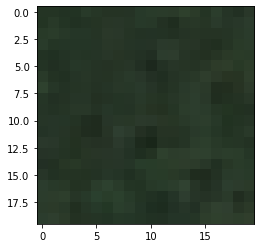

In [ ]:
plt.imshow(denormalization(test_dataset[12]['features']))